In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
sys.path.append('../models/stylegan2')
import dnnlib
import dnnlib.tflib as tflib
from run_generator import generate_images
import pretrained_networks
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import gan_helper
import sklearn.model_selection
import torch
import models
import util
import config
import viz
import os
import scipy.stats
GAN = gan_helper.Generator() # initializes gan
print('Done!')

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/pyt

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Done!


**note - look at some of the plots in `analyze_inn` nb to help with this**

# load latent-mapping model

In [3]:
orth_dict = pkl.load(open(oj(config.PROCESSED_DIR, '02_orth.pkl'), 'rb'))
orth_mat = orth_dict['vecs_orth'].transpose() # make it (512, 6)
offsets = np.array([a[0] for a in orth_dict['intercepts']])

def predict(z):
    '''Return projection onto attribute space
    z is (batch_size, 512)
    '''
    return z @ orth_mat + offsets

def increase(z, attr_index, mult):
    '''Move in direction that increases attribute a
    '''
    z_alt = z + mult * orth_mat[:, attr_index].flatten()     
    print(predict(z_alt).flatten()[attr_index], end=' ')
    return z_alt

**let's walk in face space (using shared z)**

-23.129952425334135 -15.405493272606728 -7.681034119879317 0.04342503284809441 7.767884185575504 15.492343338302915 23.21680249103033 

/home/ubuntu/face-disentanglement/src/util.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, N_IMS, N_IMS // 2 + 1)


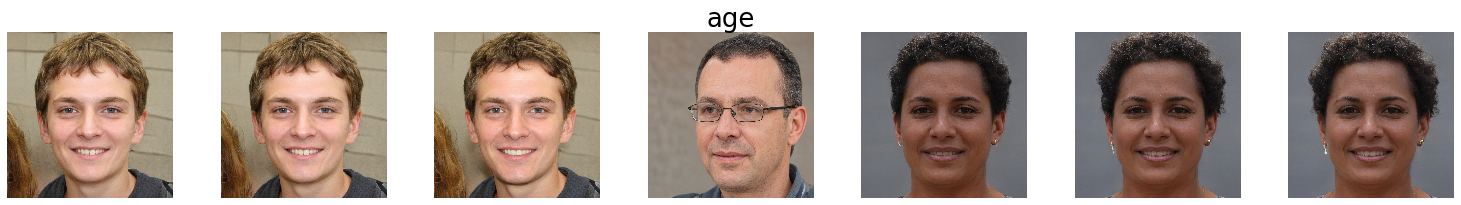

-331.53324146946267 -220.84405116524155 -110.15486086102051 0.5343294432005636 111.22351974742165 221.91271005164268 332.6019003558638 

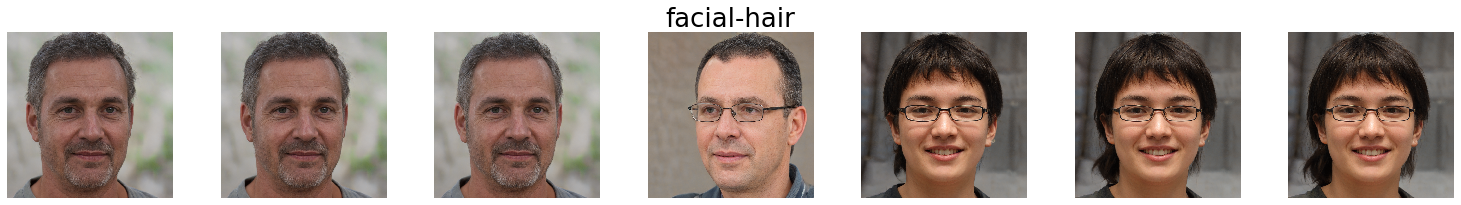

-27.50934277005087 -18.436962635247095 -9.36458250044331 -0.29220236563952795 8.780177769164256 17.85255790396804 26.924938038771824 

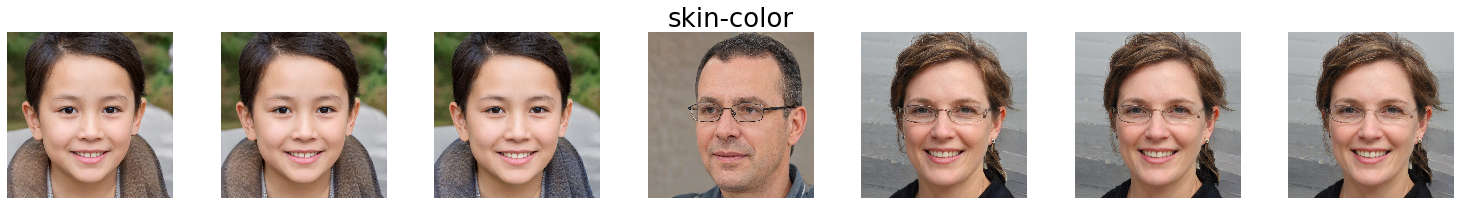

-47.509659970410794 -31.68290149566399 -15.856143020917191 -0.02938454617039432 15.797373928576404 31.62413240332321 47.45089087807 

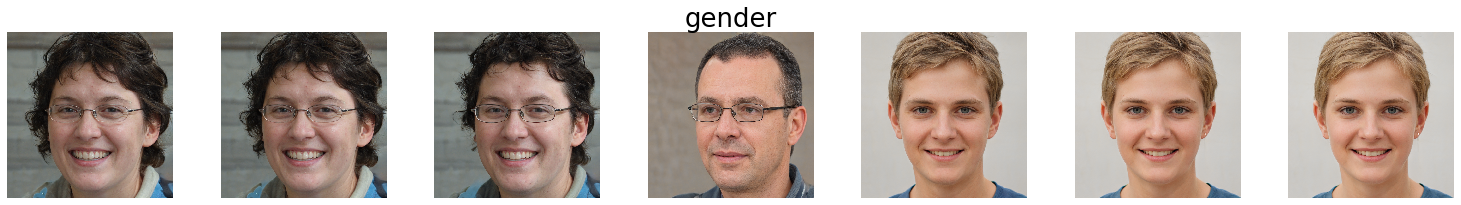

-1.5969710328816344 -1.0748611977115101 -0.552751362541386 -0.030641527371261912 0.4914683077988623 1.0135781429689863 1.5356879781391106 

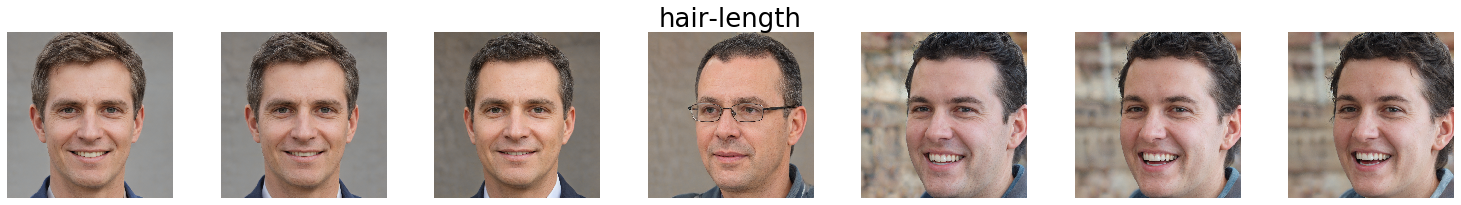

-176.13230098892288 -117.34713055635689 -58.56196012379093 0.2232103087750168 59.00838074134098 117.79355117390692 176.5787216064729 

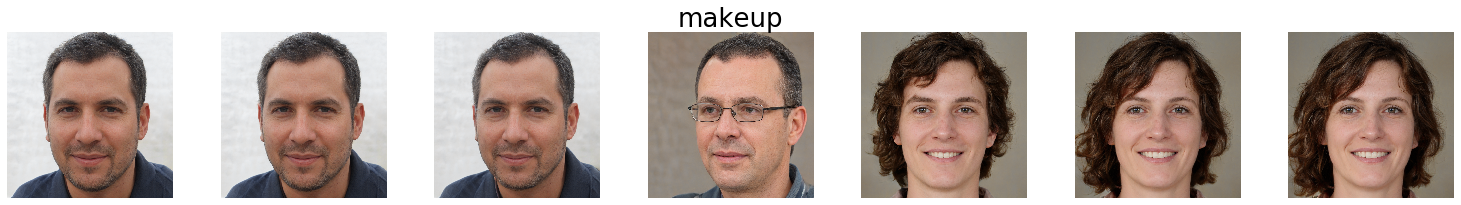

In [4]:
# # min/max to vary these attributes
# attr_bounds = { 
#     'age': (-2, 2),
#     'facial-hair': (-2, 2),
#     'skin-color': (-2, 2),
#     'gender': (-1, 1),
#     'hair-length': (-2, 2),
#     'makeup': (-2, 2)
# }
# min/max to vary these attributes
attr_mults = { 
    'age': 2,
    'facial-hair': 0.5,
    'skin-color': 2,
    'gender': 1,
    'hair-length': 2,
    'makeup': 0.25
}

# z0 = np.zeros((1, 512)) #X[1:2] * 0
z0 = np.random.randn(1, 512) * 0.1
N_IMS = 7 # should be odd

for attr_index, attr in enumerate(config.ATTRS):
    zs = np.zeros((N_IMS, 512))
    mult = 10 * attr_mults[attr] # 1e0 #5e-4
    for j in range(N_IMS):
        diff = j - N_IMS // 2
        zs[j] = increase(z0, attr_index=attr_index, mult=diff * mult)
    images = GAN.gen(np.vstack(zs))
    util.plot_row(images, suptitle=attr)
    plt.show()

# using projected images (full z)

**get a latent from embedding**

In [78]:
fnames = sorted([fname 
          for fname in os.listdir(config.REAL_LATENT_ENCODINGS_DIR)
          if '.npy' in fname])
latents = np.load(oj(config.REAL_LATENT_ENCODINGS_DIR, fnames[1]))
z0 = np.expand_dims(latents, 0)

In [ ]:
# print('z at different scales are not the same')
# viz.corrplot(np.corrcoef(latents))
# plt.colorbar()
# plt.show()

In [ ]:
# im = GAN.gen_full(z0)
# util.imshow(im)

**let's walk in face space**

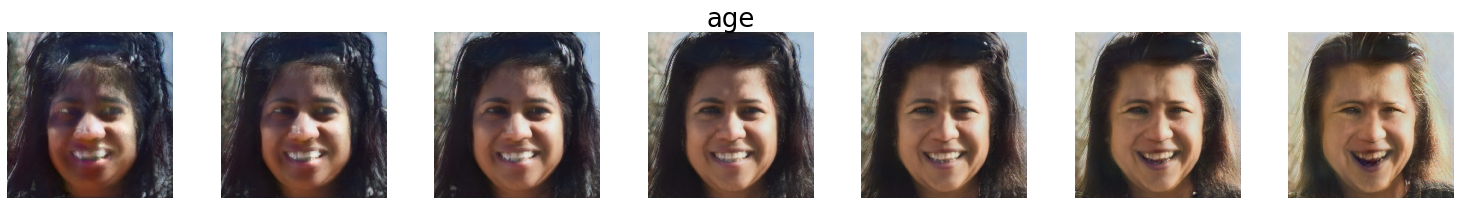

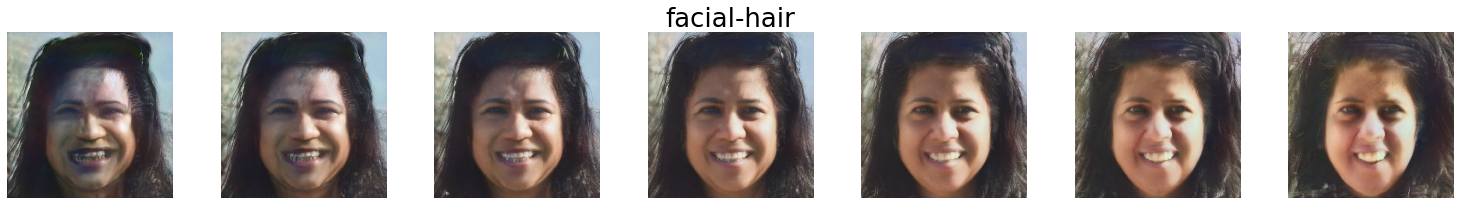

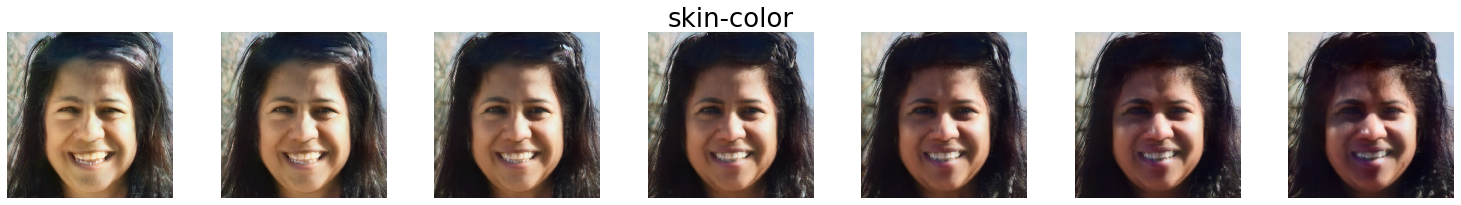

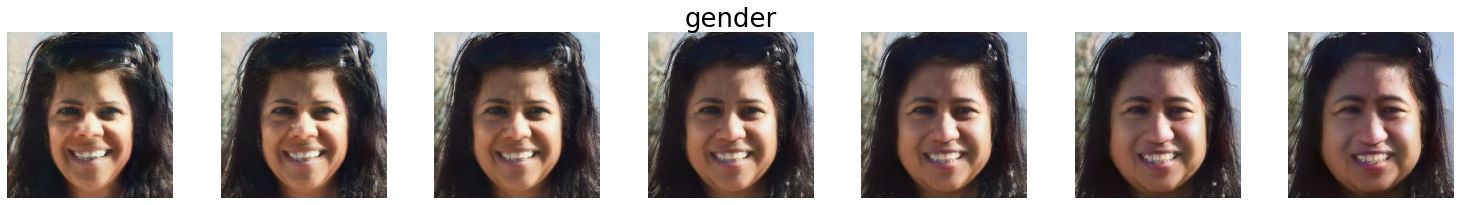

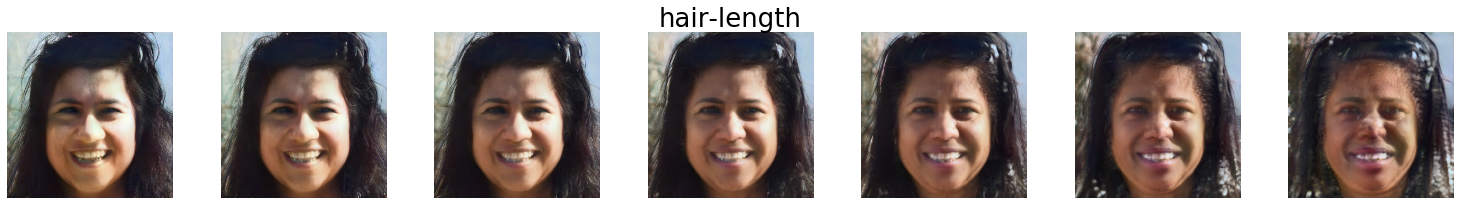

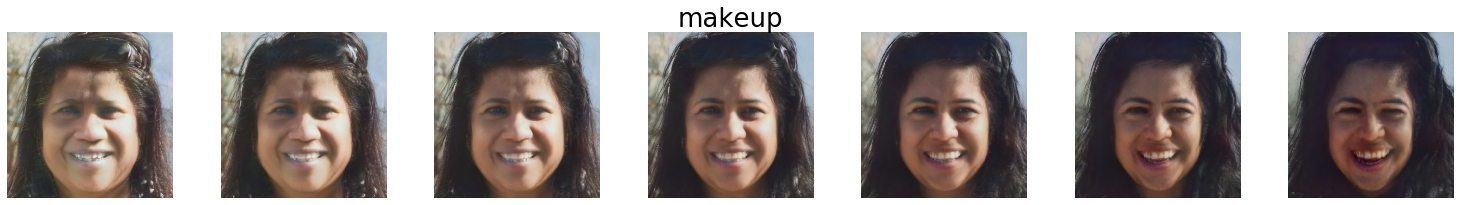

In [88]:
z0 = np.squeeze(z0)
# z0: (18, 512)
N_IMS = 7 # should be odd
MULT = 18
a = m(torch.Tensor(z0))
for attr_index, attr in enumerate(config.ATTRS):
    
    # get a mapping for z0
    a_arr = a.repeat((N_IMS, 1))
    delta = attr_deltas[attr]
    mult = 0.05
#     (bound_min, bound_max) = attr_bounds[attr]
    for j in range(N_IMS):
        diff = j - N_IMS // 2
#         a_arr[j * MULT: j * MULT + 17, attr_index] += diff * mult * delta
        a_arr[j * MULT: (j + 1) * MULT, attr_index] += diff * mult * delta
    zs = util.detach(m(a_arr, rev=True))
    zs = zs.reshape(N_IMS, MULT, -1).squeeze()
    images = GAN.gen_full(zs)
    util.plot_row(images, suptitle=attr)
    plt.show()